### VGG16 - Emotion Detection (Transfer Learning)

### Loading the VGG16 Model

In [11]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes but we will resize it to 48x48 to make it work faster
img_rows = 48
img_cols = 48 

#Loads the VGG16 model 
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

### Inpsecting each layer

In [12]:
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


### Let's freeze all layers except the top 4 

In [13]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 48
img_cols = 48 

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


### Let's make a function that returns our FC Head

In [14]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

### Let's add our FC Head back onto VGG

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 7

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

### Loading our Flowers Dataset

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'C:/Users/elton/Google Drive/AI Course/Capstone Project/emotion/data/fer2013/train'
validation_data_dir = 'C:/Users/elton/Google Drive/AI Course/Capstone Project/emotion/data/fer2013/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 1000
val_batchsize = 1000
#train_batchsize = 16
#val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 62348 images belonging to 7 classes.
Found 5743 images belonging to 7 classes.


### Training our top layers

In [17]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("C:/Users/elton/Google Drive/AI Course/Capstone Project/emotion/emotion_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          #patience = 3,(original is 3, changed to 15)
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 62348
nb_validation_samples = 5743
epochs = 100
batch_size = 1000

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    #callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

model.save("C:/Users/elton/Google Drive/AI Course/Capstone Project/emotion/emotion_vgg.h5")

Epoch 1/100
62/62 [==============================] - 85s 1s/step - loss: 1.8903 - accuracy: 0.2301 - val_loss: 1.7639 - val_accuracy: 0.2696
Epoch 2/100
62/62 [==============================] - 83s 1s/step - loss: 1.8075 - accuracy: 0.2778 - val_loss: 1.9258 - val_accuracy: 0.3163
Epoch 3/100
62/62 [==============================] - 84s 1s/step - loss: 1.7840 - accuracy: 0.2932 - val_loss: 1.6563 - val_accuracy: 0.3439
Epoch 4/100
62/62 [==============================] - 80s 1s/step - loss: 1.7722 - accuracy: 0.2989 - val_loss: 1.8255 - val_accuracy: 0.2888
Epoch 5/100
62/62 [==============================] - 79s 1s/step - loss: 1.7607 - accuracy: 0.3077 - val_loss: 1.6118 - val_accuracy: 0.3152
Epoch 6/100
62/62 [==============================] - 82s 1s/step - loss: 1.7562 - accuracy: 0.3079 - val_loss: 1.4752 - val_accuracy: 0.2891
Epoch 7/100
62/62 [==============================] - 87s 1s/step - loss: 1.7474 - accuracy: 0.3141 - val_loss: 1.5578 - val_accuracy: 0.3064
Epoch 8/100
6

In [18]:
#saving this history file
import pandas as pd

# assuming you stored your model.fit results in a 'history' variable:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history)

# save to json:  
hist_json_file = 'history_vgg16.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history_vgg16.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [19]:
model.save("emotion_vgg.h5")
print("Saved emotion model to disk")

Saved emotion model to disk


In [20]:
#ek added
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


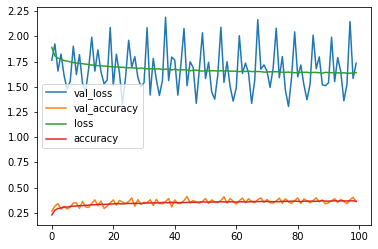

In [21]:
import pandas as pd

model_loss = pd.DataFrame(history.history)
model_loss.plot()

In [ ]:
from keras.models import load_model

classifier = load_model('emotion_vgg.h5')

Found 5743 images belonging to 7 classes.
Confusion Matrix
[[372   4 115  98  93 183 135]
 [ 76   6  16  19   8  68  16]
 [ 67   1 147  80  41  81 117]
 [ 84   1  72 479  74 144 146]
 [192   2 102 157 149 172 226]
 [173   1 114 110 122 337 143]
 [ 66   0 113  73  53  79 616]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.36      0.37      0.37      1000
     Disgust       0.40      0.03      0.05       209
        Fear       0.22      0.28      0.24       534
       Happy       0.47      0.48      0.48      1000
     Neutral       0.28      0.15      0.19      1000
         Sad       0.32      0.34      0.33      1000
    Surprise       0.44      0.62      0.51      1000

    accuracy                           0.37      5743
   macro avg       0.35      0.32      0.31      5743
weighted avg       0.36      0.37      0.35      5743



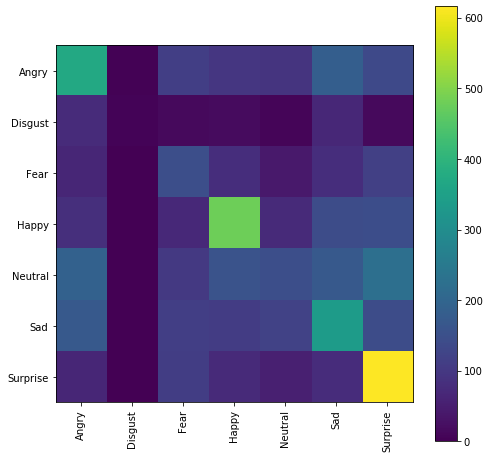

In [22]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 62348
nb_validation_samples = 5743

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        #color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)